# Split-step Fourier beam propagation method (SSF-BPM)

For nonlinear propagation in linear or chi-3 media, according to the nonlinear Schrodinger equation (NLSE).

To play with the code, you normally only need to edit the values or lines labeled with the following tag: <---### EDIT HERE ###



In [4]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special



#Setup the environment and define the computation window

In [5]:
# Computation domain discretization
Nz       = 512        # Number of steps in the z direction <---### EDIT HERE ###
Nx       = 512         # x-direction size of computational grid
Ny       = Nx          # x-direction size of computational grid. The computation domain is square
Navg     = 200    
# Physical dimension of the computation space. Physical values are denoted with an underscore. The corresponding normalized value are written without underscore.
# We use SI units
Lx_ = 200e-6     # width of the computation window [m]  <---### EDIT HERE ###
Ly_ = Lx_		   # height of the computation window [m] <---### EDIT HERE ###
Lz_ = 800e-6    # propagation distance [m]             <---### EDIT HERE ###

n0_ = 1        # linear refractive index of background    <---### EDIT HERE ###

lambda0_ = 400e-9      # free space wavelength [m]        <---### EDIT HERE ###
delta_   = 1.0			   # normalization parameter (see documentation on SSF)
n2_      = 2.4e-19	   # nonlinear coefficient [m2/W]     <---### EDIT HERE ###
V = np.zeros((Ny, Nx))    # Index potential. This correspond to the refractive index difference with respect to background
                          # for a homogeneous medium, V = 0. <---### EDIT HERE ###

#Setup the SSF-BPM variables
Normally, you shouldn't need to edit this section at all

In [6]:
# Physical constants
mu0 = 4.0e-7 * np.pi    # free space magnetic permeability [Vs/Am]
c0  = 2.99792458e+8     # free space light speed [m/s]

epsilon0 = 1.0 / (mu0 * c0**2)         # free space permittivity [As/Vm]
eta0     = np.sqrt(mu0 / epsilon0)    # free space impedance [ohm]

# Derived parameters
n2_el   = n0_ * n2_ / (2 * eta0)        # nonlinear refractive index [m2/V2]
k0_     = 2 * np.pi / lambda0_       			# free space wavenumber [m-1]
k_      = n0_ * k0_                     # medium wavenumber [m-1]
lambda_ = lambda0_ / n0_                # medium wavelength [m]

# Normalization coefficients
# The equation can be normalized to a dimensionless form
# spatial normalization factor in the x-y plane
spatial_transverse_scale = 1/(k0_ * np.sqrt(2 * n0_ *  delta_))
# spatial normalization factor in the z direction
spatial_longitudinal_scale = 1/(delta_ * k0_)

scale_ratio = spatial_longitudinal_scale/spatial_transverse_scale  # = sqrt(2*n0_/delta_)
# normalization factor for the electric field
field_scale = np.sqrt(delta_ / n2_el);

# ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

# ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

# We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * np.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * np.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*np.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * np.concatenate((np.arange(0,Ny/2,1),np.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1) 
z_  = dz_* np.arange(1,Nz+1,1) 

# Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = np.meshgrid(x_, y_)
[Xz_, Z_]   = np.meshgrid(x_, z_)
[X, Y]      = np.meshgrid(x, y)
[Xz, Z]     = np.meshgrid(x, z)

# The same for the spatial frequencies domain
[Kx, Ky]    = np.meshgrid(kx, ky)

K2 = np.multiply(Kx,Kx) + np.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again

#Definition of the input field and lenses
Here, we define the complex input field either by generating here or loading from another file

In [7]:
I_ = 1e+10                     # Peak intensity of the input beam [W/m2] <---### EDIT HERE ###
A_ = np.sqrt(2 * eta0 * I_) 	 # Peak field amplitude of the input beam [V/m]
A = A_ / field_scale       		 # normalized peak field amplitude of the input beam


# circular aperture
circular_aperture = np.zeros((Nx,Ny))
aperture_diameter  = 100e-6                # [m] <---### EDIT HERE ###
circular_aperture[X_**2+Y_**2 <= (aperture_diameter/2)**2]=1

F_lens=Lz_/4
lens=np.exp(-1j*np.pi/lambda0_/F_lens*(X_**2+Y_**2))

grating_period=20e-6
amplitude_grating=0.5+0.5*np.cos(2*np.pi*X_/grating_period)

# rectangular aperture
rectangular_aperture = np.zeros((Nx,Ny))
width_x  = 150e-6                           # [m] <---### EDIT HERE ###
width_y  = 150e-6                          # [m] <---### EDIT HERE ###
rectangular_aperture[np.logical_and(np.abs(X_)<=width_x/2,  np.abs(Y_)<=width_y/2)]=1 


# u is our input field
u = amplitude_grating*rectangular_aperture              # <---### EDIT HERE ###

# We declare this variable to monitor propagation (in the y-z plane)
fields=np.array(np.zeros((Nx,Nz)), dtype=complex)

# Assign the first step input value to be your input field
u_in = u

#Propagation routine (CORE OF THE STORY)

Now we are ready to propagate

In [8]:
output_each=np.array(np.zeros((Nx,Ny,Navg)), dtype=complex)
input_each=np.array(np.zeros((Nx,Ny,Navg)), dtype=complex)
output=np.array(np.zeros((Nx,Ny)), dtype=complex)

t_start = time.time()
count=0
for index_avg in range(Navg):
  count=count+1
  noise=np.random.normal(0, .1, u.shape)
  incident=noise*u_in
  input_each[:,:,index_avg]=np.abs(incident)**2
  u0=incident
  # paraxial code
  u0=np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j*K2*1*dz*Nz/4))
  u0=u0*lens
  u0=np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j*K2*1*dz*Nz/4))
  u0=u0*circular_aperture
  u0=np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j*K2*1*dz*Nz/4))
  u0=u0*lens
  u0=np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j*K2*1*dz*Nz/4))

  output_each[:,:,index_avg]=u0
  output=output+np.abs(u0)**2


t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

time elapsed: 44.44535160064697 seconds


#Display results

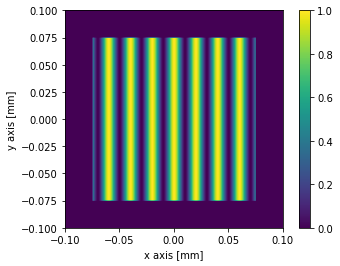

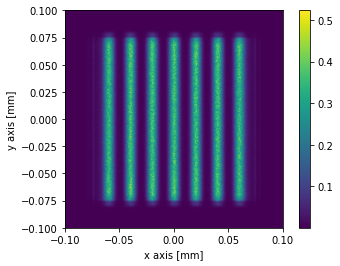

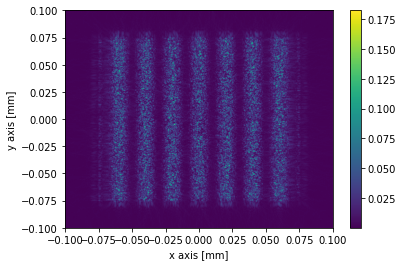

In [9]:
plt.imshow(np.abs(u),extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.show()

plt.imshow(np.abs(output),extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.show()

plt.imshow(np.squeeze(np.abs(output_each[:,:,100])),aspect='auto',extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.show()